# 계약 유지,유예율 산출  
 1. 곰스목록 최근 1년치를 다운받은 후 실행  : 아래 파일명 2개 수정 필요  
 2. logic  
   - 전처리: 지점변환, 직영/지사 구분  
   - 상태판정:  작업기준일에 따라 응당회차 계산됨을 유의  
     미유지(실효,해지, 2회 초과 지연),  유예(2회 지연)  
   - 결과 출력  

In [1]:
import pandas as pd
import mypkgs.MyDateUtil as MyU  #자체 유틸리티 클래스 로딩
import mypkgs.GladUtil as glad

from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')
getDT = MyU.getDateUtil()

In [2]:
def preProc(dfT,Method):
    dfT= dfT[(dfT.NO!='합계') & (dfT.계약종류.isin(['장기','생보']))]   #불필요 데이터 삭제
    
    dfT.rename(columns={'납입주기(방법)':'납입방법'}, inplace=True)
#     temp = df.loc[df['납입주기(방법)']=='년납','초회보험료'] / 12
#     dfT.loc[dfT.납입방법=='년납','초회보험료'] = temp
    
    dfT['계약일자']=pd.to_datetime(dfT.계약일자,format='%Y-%m-%d')
    dfT['최종상태변경일']=pd.to_datetime(dfT.최종상태변경일,format='%Y-%m-%d')
    dfT['말일']=pd.to_datetime(dfT.계약일자.map(getDT.get_lastday))
     
    dfT['월말계약상태']= dfT.계약상태
    dfT.loc[dfT.말일 < dfT.최종상태변경일,'월말계약상태']='정상'
    if Method=='계약월':
        dfT=dfT[dfT.월말계약상태=='정상']  #계약월 기준인 경우 계약월말 정상건만 추출
 
    dfT=glad.BrhConv(dfT,'지점그룹')  #지점그룹 생성 / 메트로 코드 분리
    dfT['영업일차']=dfT.계약일자.map(getDT.get_workdaysMonth)
    dfT['월']= dfT.계약일자.map(lambda x: datetime.strftime(x,"%Y-%m")[2:]+'월')
    return dfT

def 응당회차(mth, st,en, seq):
    if mth=='월납':
        return (en.year-st.year)*12+(en.month-st.month)+1
    else: return seq

def 유지상태(status, st,en):
    if status in(code1): return '철취'
    elif status in(code): 
          if en - st > 2 : return '미유지'  #미납 2회 초과
          elif en - st == 2: return '유예'  #미납 2회
          else: return '정상'
    else: return '미유지'    

In [3]:
f1='d:/글로벌/실적분석/곰스1903-1909.xlsx'
f2='d:/글로벌/실적분석/곰스1910-2002.xlsx'

df=pd.concat([pd.read_excel(f1),pd.read_excel(f2)])
# df=pd.read_excel(f2)
df.reset_index()

df=preProc(df,'현재월')
df= df.reset_index().drop(columns='index') #인데스재생성

 ## 상태판정기준일: 작업일에 따라 변경처리할 것
en='2020-02-29'   
en=datetime.strptime(en,'%Y-%m-%d')

#미유지건 전처리
code=['정상','부활']
code1=['철회','반송','취소','품보']

df['응당회차']=df.apply(lambda x: 응당회차(x.납입방법,x.계약일자,en,x.납입회차),axis=1)
df['유지상태']=df.apply(lambda x: 유지상태(x.계약상태,x.납입회차,x.응당회차),axis=1)

dft=pd.pivot_table(df, index=['지점그룹','지점','수금사원명'],columns='유지상태',values='초회보험료'
      ,aggfunc=sum,fill_value=0).reset_index()
dft['모집액']=dft.정상+dft.미유지+dft.유예+dft.철취
dft['성립액']=dft.정상+dft.미유지+dft.유예
dft['유지율']=((dft.정상+dft.유예)/ (dft.성립액) * 100).fillna(0)
dft['유예율']=(dft.유예/ (dft.성립액) * 100).fillna(0)
dft['철취율']=(dft.철취/ (dft.모집액) * 100).fillna(0)

In [4]:
cols=['지점','수금사원명','모집액','철취','성립액','정상','유예','미유지','유지율','유예율','철취율']
wr1=dft[dft.지점그룹=='직영'].sort_values('유예율',ascending=False)
wr1=wr1.loc[:,cols]

cols=['지점','수금사원명','증권번호','보험사','계약일자','상품명','유지상태','납입회차','응당회차','최종수금일']
wr2=df.loc[(df.지점그룹=='직영') & (df.유지상태.isin(['유예','미유지'])), cols]

outFile='d:/글로벌/실적분석/장기유지분석.xlsx'
with pd.ExcelWriter(outFile) as writer:  
    wr1.to_excel(writer, sheet_name='요약',index=False)
    wr2.to_excel(writer, sheet_name='목록',index=False) 
# wr.to_excel('d:/글로벌/실적분석/장기유지분석.xlsx')
# del wr1, wr2

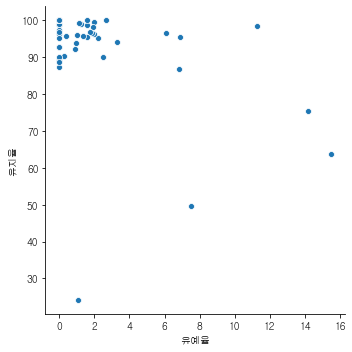

In [11]:
# sns.relplot(x="유예율", y="유지율", hue="수금사원명", data=wr1)
sns.relplot(x="유예율", y="유지율", data=wr1)

In [102]:
## 계약자 중복 비율 분석
# df1=df.loc[df.수금사원명=='박인선',['계약자','피보험자','계약일자','유지상태','보험사','초회보험료']]
df1=df.loc[:,['지점그룹','지점','수금사원명','계약자','피보험자','계약일자','유지상태','보험사','초회보험료']]

df2=pd.DataFrame(df1.groupby(['지점그룹','지점','수금사원명','계약자'])['계약일자'].count()).reset_index()
df3=df2.groupby(['지점그룹','지점','수금사원명'])['계약일자'].agg(['sum','count']).reset_index()
df3.rename(columns={'sum':'합계','count':'중복제거'},inplace=True)
df3['비율']=df3['중복제거'] / df3['합계']
df3[df3.지점그룹=='직영'].sort_values(by='비율',ascending=True).head(60)
# df1[df1.수금사원명=='신승휴'].sort_values(by=['계약자'])

,지점그룹,지점,수금사원명,계약자,피보험자,계약일자,유지상태,보험사,초회보험료
10078,직영,엠피레전드,신승휴,김동수,김동수,2020-02-12,정상,롯데손보,187091
729,직영,엠피레전드,신승휴,김문섭,태아,2019-09-11,정상,DB손보,22070
728,직영,엠피레전드,신승휴,김문섭,태아,2019-09-11,정상,DB손보,12160
724,직영,엠피레전드,신승휴,김문섭,NGUYEN THI THAO,2019-09-11,정상,DB손보,8910
725,직영,엠피레전드,신승휴,김문섭,NGUYEN THI THAO,2019-09-11,정상,DB손보,98360
...,...,...,...,...,...,...,...,...,...
7904,직영,엠피레전드,신승휴,최영호,NaN,2019-03-29,정상,메리츠화재,35000
7903,직영,엠피레전드,신승휴,최영호,최영호,2019-03-29,정상,DB손보,14930
7902,직영,엠피레전드,신승휴,최영호,최영호,2019-03-29,정상,DB손보,212290
1238,직영,엠피레전드,신승휴,허필성,허동영,2019-08-30,정상,흥국화재,176499


유지상태,지점,수금사원명,모집액,철취,성립액,정상,유예,미유지,유지율,유예율,철취율
128,엠피성공,박인선,4666799,35374,4631425,2235433,718255,1677737,63.774929,15.508294,0.757993
115,엠피레전드,박윤나,1782589,0,1782589,1090532,253000,439057,75.369701,14.192840,0.000000
156,엠피여주,이성구,3262804,153600,3109204,2708633,350571,50000,98.391871,11.275265,4.707607
153,엠피여주,김양운,2605140,0,2605140,1101440,195410,1308290,49.780434,7.500940,0.000000
133,엠피성공,전용순,16902888,1077832,15825056,14039222,1089233,696601,95.598114,6.882965,6.376614
...,...,...,...,...,...,...,...,...,...,...,...
119,엠피레전드,이광호,3239400,167329,3072071,2972071,0,100000,96.744867,0.000000,5.165432
143,엠피송내,이여진,1015870,0,1015870,915800,0,100070,90.149330,0.000000,0.000000
118,엠피레전드,안인희,1773867,0,1773867,1572517,0,201350,88.649093,0.000000,0.000000
116,엠피레전드,박진숙,930354,0,930354,930354,0,0,100.000000,0.000000,0.000000
